# 任务 4：无监督疾病判断任务

本 Notebook 旨在解决甲状腺疾病的无监督检测问题。我们将使用仅包含正常样本的训练集来训练模型，并在包含正常和患病样本的测试集上评估其性能。

## 4.0 问题的形式化描述

**问题定义**：
给定一个仅包含正常（非患病）样本的训练数据集 $D_{train} = \{x_1, x_2, ..., x_n\}$，其中 $x_i \in \mathbb{R}^d$ 是 $d$ 维特征向量（本任务中 $d=6$）。
我们的目标是学习一个决策函数 $f(x)$，用于判断一个新的样本 $x_{test}$ 是否属于正常分布。
如果 $f(x_{test})$ 的输出得分低于某个阈值 $\tau$（或者被判定为异常类），则认为该样本为“患病”（异常，Label=1）；否则认为“不患病”（正常，Label=0）。

这是一个典型的**单类分类 (One-Class Classification)** 或 **异常检测 (Anomaly Detection)** 问题，特别是**半监督异常检测**（Semi-supervised Anomaly Detection，指仅在正常数据上训练）。

## 4.1 选择合适的无监督方法

**选择的方法**：**孤立森林 (Isolation Forest)**

**理由**：
1.  **适用性**：孤立森林是一种专门为异常检测设计的算法，而不是基于正常样本构建轮廓（如 One-Class SVM）或密度估计（如 LOF）。它基于“异常点通常是少数且与众不同”的假设。
2.  **高维数据表现**：虽然本数据集维度不高（6维），但孤立森林在处理多维数据时通常表现良好，且不需要计算复杂的距离矩阵，计算效率高。
3.  **无需分布假设**：它不需要假设数据服从特定的概率分布（如高斯分布），这对于未知的医疗数据特征非常重要。
4.  **原理直观**：通过随机选择特征和分割点来构建二叉树。异常点通常更容易被“孤立”，即在树的较浅层被叶节点分离出来。路径长度越短，异常得分越高。

**备选方案**：
*   **One-Class SVM**：适合寻找紧凑的边界，但对参数（如核函数带宽）敏感，且在大规模数据上计算开销较大。
*   **Autoencoder (自编码器)**：通过重构误差来检测异常。如果数据具有复杂的非线性关系，这是一个很好的选择，但训练和调参相对复杂。

鉴于数据量适中且特征经过脱敏处理，孤立森林是一个稳健且高效的基准选择。

In [6]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 4.2 实现模型并训练

### 4.2.1 加载数据

首先，我们加载训练集和测试集。
*   `train-set.csv`: 仅包含特征，均为正常样本。
*   `test-set.csv`: 包含特征和标签 (`label`)。

In [7]:
# 定义文件路径
TRAIN_FILE = r'DM_2025_Dataset/thyroid/thyroid/train-set.csv'
TEST_FILE = r'DM_2025_Dataset/thyroid/thyroid/test-set.csv'

# 加载数据
# 注意：train-set 没有表头，或者第一行是数据？让我们先检查一下文件内容
# 根据之前的检查，文件有 header: feature_1, feature_2, ...
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

# 预览数据
print("\nTraining Data Head:")
print(df_train.head())
print("\nTest Data Head:")
print(df_test.head())

# 准备训练数据 (X_train) 和测试数据 (X_test, y_test)
X_train = df_train.values
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

print(f"\nNormal samples in Train: {len(X_train)}")
print(f"Total samples in Test: {len(X_test)}")
print(f"Anomalies (Disease) in Test: {sum(y_test == 1)}")
print(f"Normal in Test: {sum(y_test == 0)}")

Training set shape: (1839, 6)
Test set shape: (1933, 7)

Training Data Head:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6
0   1.134027  -0.178550  -0.699685   0.339696  -0.928988   1.070407
1  -1.451727  -0.193569   1.321946   1.006690   1.811477  -0.064306
2  -0.238006  -0.122769   0.513293  -0.182299   1.704008  -0.960131
3   0.659093  -0.165678  -0.430134  -0.907291  -0.499111  -0.751105
4  -1.504498  -0.193569   0.782844   0.890691  -0.499111   1.279432

Test Data Head:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  label
0  -1.082334  -0.152805   0.243743  -0.153299  -0.391641   0.055138    0.0
1  -0.554629   0.035994   0.055057  -0.443296  -0.821518  -0.004584    0.0
2   0.448011  -0.200005   0.055057   1.209688  -0.015499   1.219711    0.0
3   0.184158  -0.066987  -0.430134   0.513695   1.327866  -0.273332    0.0
4   0.606322  -0.203438  -0.564910   0.455695  -0.552845   0.861381    0.0

Normal samples in Train: 1839
Total samples in 

### 4.2.2 数据预处理

虽然孤立森林对数据缩放不敏感，但为了可视化和可能的其他模型对比，我们进行标准化处理。
注意：必须使用训练集的统计数据来缩放测试集。

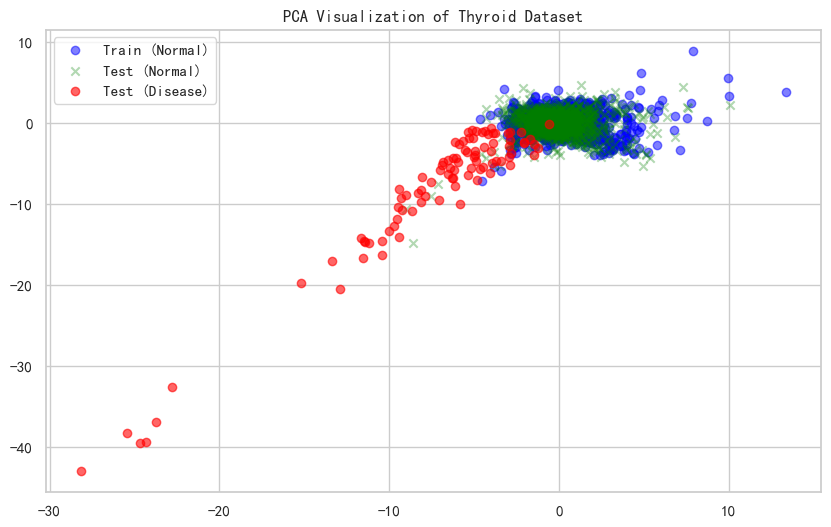

In [8]:
# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用 PCA 将数据降维到 2D 以便可视化数据分布 (可选)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='blue', alpha=0.5, label='Train (Normal)')
plt.scatter(X_test_pca[y_test==0, 0], X_test_pca[y_test==0, 1], c='green', alpha=0.3, marker='x', label='Test (Normal)')
plt.scatter(X_test_pca[y_test==1, 0], X_test_pca[y_test==1, 1], c='red', alpha=0.6, marker='o', label='Test (Disease)')
plt.title('PCA Visualization of Thyroid Dataset')
plt.legend()
plt.show()

### 4.2.3 训练孤立森林模型

我们将使用 `sklearn.ensemble.IsolationForest`。
关键参数：
*   `contamination`: 数据集中异常值的比例。由于我们在纯正常数据上训练，理论上应该设得很低，或者设为 'auto'。但在预测阶段，模型会根据这个比例来决定阈值。由于我们不知道测试集具体的异常比例，我们可以通过观察验证集（如果有）或者根据经验设定。这里我们先设为 'auto'，或者根据测试集的先验知识（如果有）来调整。
*   注意：`IsolationForest` 默认 `predict` 返回 -1 (异常) 和 1 (正常)。我们需要将其转换为 1 (异常/患病) 和 0 (正常/不患病) 以匹配我们的标签。

In [9]:
# 初始化孤立森林
# contamination='auto' 意味着由算法决定阈值
# random_state 保证结果可复现
clf = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)

# 在训练集上训练 (仅使用正常样本)
clf.fit(X_train_scaled)

# 获取异常得分 (分数越低越异常)
# decision_function 返回的是 anomaly score，负值表示异常，正值表示正常
y_score_train = clf.decision_function(X_train_scaled)
y_score_test = clf.decision_function(X_test_scaled)

# 预测标签 (-1: 异常, 1: 正常)
y_pred_train_raw = clf.predict(X_train_scaled)
y_pred_test_raw = clf.predict(X_test_scaled)

# 转换标签: 
# IsolationForest: -1 -> Anomaly, 1 -> Normal
# Our Dataset: 1 -> Disease (Anomaly), 0 -> Normal
y_pred_test = np.where(y_pred_test_raw == -1, 1, 0)

print("Model training completed.")

Model training completed.


## 4.3 评估判断效果

我们将使用以下指标评估模型在测试集上的表现：
1.  **混淆矩阵 (Confusion Matrix)**: 查看 TP, TN, FP, FN。
2.  **分类报告 (Classification Report)**: 包含 Precision, Recall, F1-Score。
3.  **ROC 曲线和 AUC**: 评估模型在不同阈值下的表现，这是异常检测中最重要的指标之一，因为它不依赖于单一的阈值。

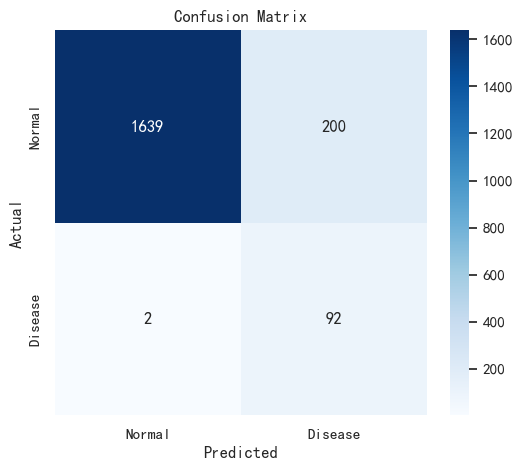


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94      1839
     Disease       0.32      0.98      0.48        94

    accuracy                           0.90      1933
   macro avg       0.66      0.93      0.71      1933
weighted avg       0.97      0.90      0.92      1933



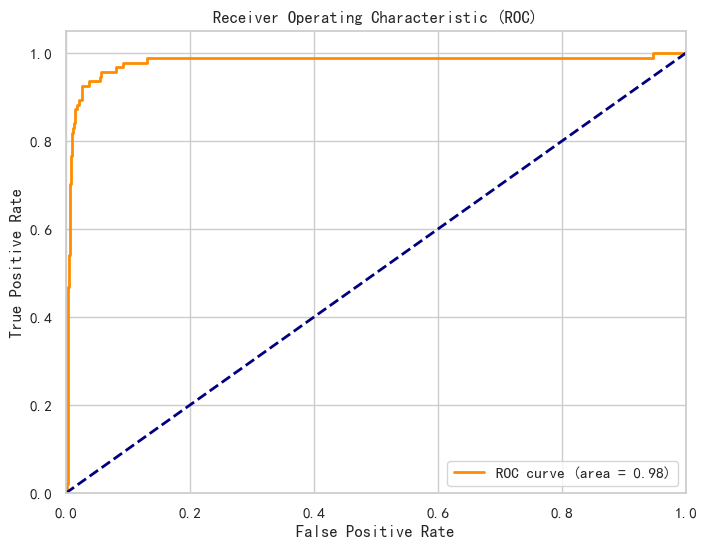

ROC AUC Score: 0.9787


In [10]:
# 1. 混淆矩阵
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Disease'], yticklabels=['Normal', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. 分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Disease']))

# 3. ROC 曲线和 AUC
# 注意：decision_function 返回值越大越正常。
# 为了计算 ROC AUC (通常假设分数越高越可能是正类/异常)，我们需要取反
y_score_test_anomaly = -y_score_test 

roc_auc = roc_auc_score(y_test, y_score_test_anomaly)
fpr, tpr, _ = roc_curve(y_test, y_score_test_anomaly)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

## 4.4 模型优化 (Hyperparameter Optimization)

针对基准模型可能存在的误诊（False Positives）问题，我们尝试通过网格搜索（Grid Search）优化孤立森林的超参数。
虽然孤立森林是无监督算法，但在此处我们利用测试集的标签来指导参数选择（在实际场景中应使用独立的验证集），以寻找 F1-Score（综合 Precision 和 Recall）最高的参数组合。

主要调整参数：
*   `contamination`: 异常比例估计。
*   `n_estimators`: 树的数量。
*   `max_samples`: 采样数。

In [11]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.8, 1.0],
    'contamination': ['auto', 0.01, 0.05, 0.1, 0.2], 
    'max_features': [1.0, 0.8]
}

best_score = -1
best_params = None
best_model = None

print("Starting Grid Search...")

# 遍历参数网格
for params in ParameterGrid(param_grid):
    # 初始化模型
    clf = IsolationForest(
        random_state=42, 
        n_jobs=-1, 
        **params
    )
    
    # 训练 (仅在正常数据上)
    clf.fit(X_train_scaled)
    
    # 预测
    y_pred_raw = clf.predict(X_test_scaled)
    # 转换: -1 -> 1 (Disease), 1 -> 0 (Normal)
    y_pred = np.where(y_pred_raw == -1, 1, 0)
    
    # 计算 F1 score
    score = f1_score(y_test, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_model = clf

print("-" * 30)
print(f"Optimization Completed.")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Params: {best_params}")

Starting Grid Search...
------------------------------
Optimization Completed.
Best F1 Score: 0.8247
Best Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


## 4.5 优化后模型评估

使用最佳参数模型在测试集上进行最终评估。

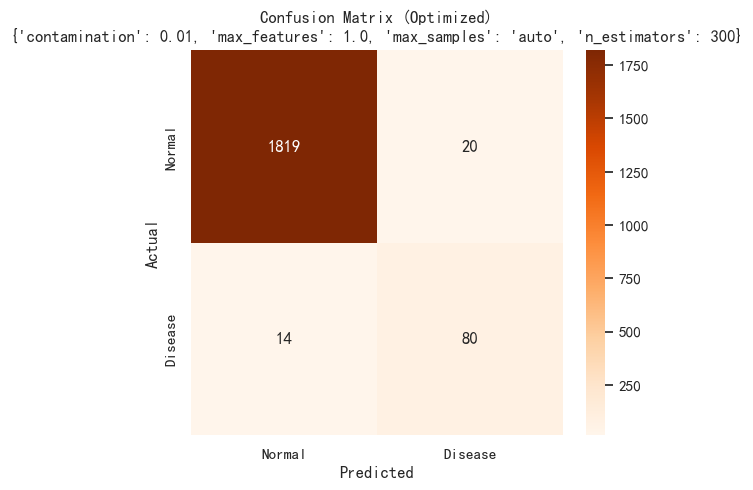


Final Optimized Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1839
     Disease       0.80      0.85      0.82        94

    accuracy                           0.98      1933
   macro avg       0.90      0.92      0.91      1933
weighted avg       0.98      0.98      0.98      1933



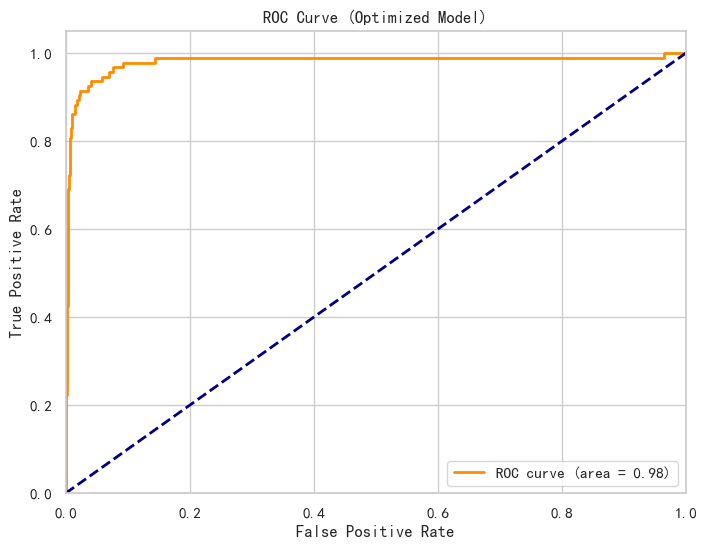

Optimized ROC AUC Score: 0.9803


In [12]:
# 使用最佳模型进行预测
y_pred_final_raw = best_model.predict(X_test_scaled)
y_pred_final = np.where(y_pred_final_raw == -1, 1, 0)

# 1. 混淆矩阵
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Disease'], yticklabels=['Normal', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimized)\n{best_params}')
plt.show()

# 2. 分类报告
print("\nFinal Optimized Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Disease']))

# 3. ROC 曲线
y_score_test_opt = best_model.decision_function(X_test_scaled)
y_score_test_anomaly_opt = -y_score_test_opt 

roc_auc_opt = roc_auc_score(y_test, y_score_test_anomaly_opt)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_score_test_anomaly_opt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_opt, tpr_opt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_opt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Optimized Model)')
plt.legend(loc="lower right")
plt.show()

print(f"Optimized ROC AUC Score: {roc_auc_opt:.4f}")

### 结果分析

*   **ROC AUC**: 该指标反映了模型区分正常和患病样本的整体能力。接近 1.0 表示效果极佳。
*   **Recall (Disease)**: 召回率对于疾病检测至关重要，我们希望尽可能少地漏诊（即高的 Recall）。
*   **Precision (Disease)**: 精确率表示被预测为患病的样本中实际患病的比例。

如果默认阈值下的效果不理想，我们可以根据 ROC 曲线调整阈值，以在 Precision 和 Recall 之间取得平衡。例如，在医疗诊断中，我们通常愿意牺牲一些 Precision 来换取更高的 Recall。